In [1]:
! pip install psycopg2-binary
! pip install cachetools
! pip install pandas
! pip install seaborn
! pip install ipywidgets

import psycopg2
import psycopg2.extras

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import heapq as hq

from cachetools import cached, TTLCache

import time

In [2]:
sns.set(rc={'figure.figsize':(15, 10)})

In [3]:
def create_connection():
    dbname = 'fileserver'
    user = 'user'
    password = 'secret'
    host = '192.168.0.2'
    return psycopg2.connect(dbname=dbname, user=user, password=password, host=host)

In [4]:
def fetch_devices(connection):
	with connection.cursor() as cursor:
		cursor.execute(f"""SELECT DISTINCT device_id, sensor_name FROM sensor_data""")
		return [(row[0], row[1]) for row in cursor.fetchall()]

def fetch_tail(connection, device_id, sensor_name, include_timestamp=False):
	with connection.cursor() as cursor:
		sql = f"""WITH last_received_at AS (
					SELECT MAX(received_at) as last_received_at
					FROM sensor_data
					JOIN sensor_data_weights USING (id)
					WHERE device_id = %s AND sensor_name = %s
				), last_peak AS (
					SELECT *
					FROM sensor_data
					JOIN sensor_data_weights USING (id)
					WHERE device_id = %s AND sensor_name = %s
					AND received_at > (SELECT last_received_at - interval '5 minute'  FROM last_received_at)
					ORDER BY weight DESC
					LIMIT 1
				)
				SELECT id, sensor_value {', received_at ' if include_timestamp else ''}
				FROM sensor_data
				WHERE device_id = %s AND sensor_name = %s AND id >= COALESCE((SELECT id FROM last_peak), 0)
				ORDER BY received_at ASC"""
		cursor.execute(sql, (device_id, sensor_name, device_id, sensor_name, device_id, sensor_name))
		
		columns = ['id', 'sensor_value']
		if include_timestamp:
			columns.append('received_at')
		return pd.DataFrame.from_records(cursor.fetchall(), index=['id'], columns=columns)

def fetch(connection, device_id, sensor_name, include_timestamp=False):
	with connection.cursor() as cursor:
		sql = f"""SELECT id, sensor_value {', received_at ' if include_timestamp else ''} 
			FROM sensor_data
			WHERE device_id = %s AND sensor_name = %s
			ORDER BY received_at ASC"""
		cursor.execute(sql, (device_id, sensor_name))
		
		columns = ['id', 'sensor_value']
		if include_timestamp:
			columns.append('received_at')
		return pd.DataFrame.from_records(cursor.fetchall(), index=['id'], columns=columns)

def fetch_smart_ui(connection, device_id, sensor_name, limit = 1000):
	with connection.cursor() as cursor:
		sql = f"""(SELECT id, sensor_value, received_at
				FROM sensor_data
				WHERE device_id = %s AND sensor_name = %s
				ORDER BY id ASC LIMIT 1)
				UNION
				(SELECT id, sensor_value, received_at
				FROM sensor_data
				JOIN sensor_data_weights USING (id)
				WHERE device_id = %s AND sensor_name = %s
				ORDER BY weight DESC LIMIT %s)
				UNION
				(SELECT id, sensor_value, received_at
				FROM sensor_data
				WHERE device_id = %s AND sensor_name = %s
				ORDER BY id DESC LIMIT 1)"""
		cursor.execute(sql, (device_id, sensor_name, device_id, sensor_name, limit, device_id, sensor_name))
		
		columns = ['id', 'sensor_value', 'received_at']
		return pd.DataFrame.from_records(cursor.fetchall(), index=['id'], columns=columns)

def fetch_statistics(connection, sensor, signal, device_id):
	with connection.cursor() as cursor:
		sql = f"""SELECT avg({signal}), stddev_pop({signal}) FROM sensor_data_{sensor} WHERE device_id = %s"""
		cursor.execute(sql, (device_id,))
		return cursor.fetchone()

def fetch_weights(connection, sensor, signal, device_id):
	with connection.cursor() as cursor:
		sql = f"""	SELECT id, weight
					FROM sensor_data_{sensor}
					JOIN weights_{sensor}_{signal} USING (id)
					WHERE device_id = %s
					ORDER BY id"""
		cursor.execute(sql, (device_id,))

		columns = ['id', 'weight']
		df = pd.DataFrame.from_records(cursor.fetchall(), index=['id'], columns=columns)
		df.weight = df.weight.astype('float')
		return df

def fetch_scd30_ppm():
	with create_connection() as connection:
		return fetch(connection, 3, 'ppm', include_timestamp=True)

def fetch_scd30_ppm_smart(limit = 1000):
	with create_connection() as connection:
		return fetch_smart_ui(connection, 3, 'ppm', limit)

def fetch_scd30_ppm_weights():
	with create_connection() as connection:
		return fetch_weights(connection, 'scd30', 'ppm', 'zero')

def fetch_sgp40_voc():
	with create_connection() as connection:
		return fetch(connection, 'sgp40', 'voc', 'zero', include_timestamp=True)

In [5]:
def remove_old_data(connection):
	with connection.cursor() as cursor:
		cursor.execute(f"""DELETE FROM sensor_data
		WHERE received_at < now() - interval '1 week'""")

def update_weight(connection, series):
	with connection.cursor() as cursor:
		sql = f"""INSERT INTO sensor_data_weights (id, weight) VALUES %s
		ON CONFLICT (id) DO UPDATE SET weight = EXCLUDED.weight
		WHERE sensor_data_weights.weight < EXCLUDED.weight"""
		data = [(id, weight) for id, weight in series.items()]
		psycopg2.extras.execute_values(cursor, sql, data)

In [6]:
def calculate_weights(data, ratio = 1):
    y = data
    x = np.arange(len(y))
    indeces = {0:0, len(y)-1:0}

    processed = 2
    limit = max(10, int(len(data) * ratio))

    queue = []
    hq.heappush(queue, (0, (0, len(y)-1)))

    while queue and processed < limit:
        _, (left, right) = hq.heappop(queue)

        if right - left == 1:
            continue

        y_range = y[left:right + 1]
        x_range = x[left:right + 1]
        
        x1, y1, x2, y2 = x_range[0], y_range[0], x_range[-1], y_range[-1]
        a = (y2 - y1) / (x2 - x1)
        b = -x1 * (y2 - y1) / (x2 - x1) + y1
        y_hat = a*x_range + b
        diff = np.abs(y_range - y_hat)
        diff = diff[1:-1]

        i = np.argmax(diff)
        error = diff[i]
        i += left + 1

        indeces[i] = error
        hq.heappush(queue, (-error, (left, i)))
        hq.heappush(queue, (-error, (i, right)))
        processed += 1 

    indeces = dict(sorted(indeces.items(), key=lambda item: item[0]))
    return np.array([indeces[x] if x in indeces.keys() else 0 for x in x])

In [7]:
def calculate_weights_for_series(series, ratio=1):
    data = series.to_numpy()
    start = time.time()
    weight = calculate_weights(data, ratio)
    end = time.time()
    print(f"weight calculation took {end-start:.2f}")

    return pd.Series(index=series.index, data=weight)

In [8]:
def process_weights():
    with create_connection() as connection:
            remove_old_data(connection)
            sensor_streams = fetch_devices(connection)
            for device_id, sensor_name in sensor_streams:
                df = fetch_tail(connection, device_id, sensor_name)
                
                print(f"{device_id}/{sensor_name} tail length {len(df)}")
                
                df.sensor_value = df.sensor_value.astype(float)

                if len(df.sensor_value) == 0:
                     continue
                
                weights = calculate_weights_for_series(df.sensor_value)
                weights = weights[weights > 0]
                update_weight(connection, weights)
    connection.commit()

In [9]:
process_weights()

3/humidity tail length 128
weight calculation took 0.00
3/ppm tail length 114
weight calculation took 0.00
3/temperature tail length 141
weight calculation took 0.00
3/voc tail length 212
weight calculation took 0.00


In [10]:
data = fetch(create_connection(), 3, 'ppm')

In [11]:
data

,sensor_value
id,
1254900,629.777282714844
1254904,629.920104980469
1254909,630.260192871094
1254913,631.033447265625
1254918,631.673583984375
...,...
2448236,635.947082519531
2448249,634.531921386719
2448253,634.576782226562


In [12]:
weights = fetch_scd30_ppm_weights()
weights['log_weight'] = np.log(weights.weight)
#sns.histplot(data=weights, x="log_weight")

mean_weight = np.mean(weights.weight)
median_weight = np.median(weights.weight)
mean_log_weight = np.mean(weights.log_weight)
median_log_weight = np.median(weights.log_weight)

print(f"mean: {mean_weight}, median: {median_weight}, mean_log: {mean_log_weight}, median_log:{median_log_weight}")

print(len(weights.weight[weights.weight > mean_weight]))
print(len(weights.weight[weights.weight > median_weight]))
print(len(weights.log_weight[weights.log_weight > mean_log_weight]))
print(len(weights.log_weight[weights.log_weight > median_log_weight]))


UndefinedTable: relation "sensor_data_scd30" does not exist
LINE 2:      FROM sensor_data_scd30
                  ^


1002 265285


KeyboardInterrupt: 

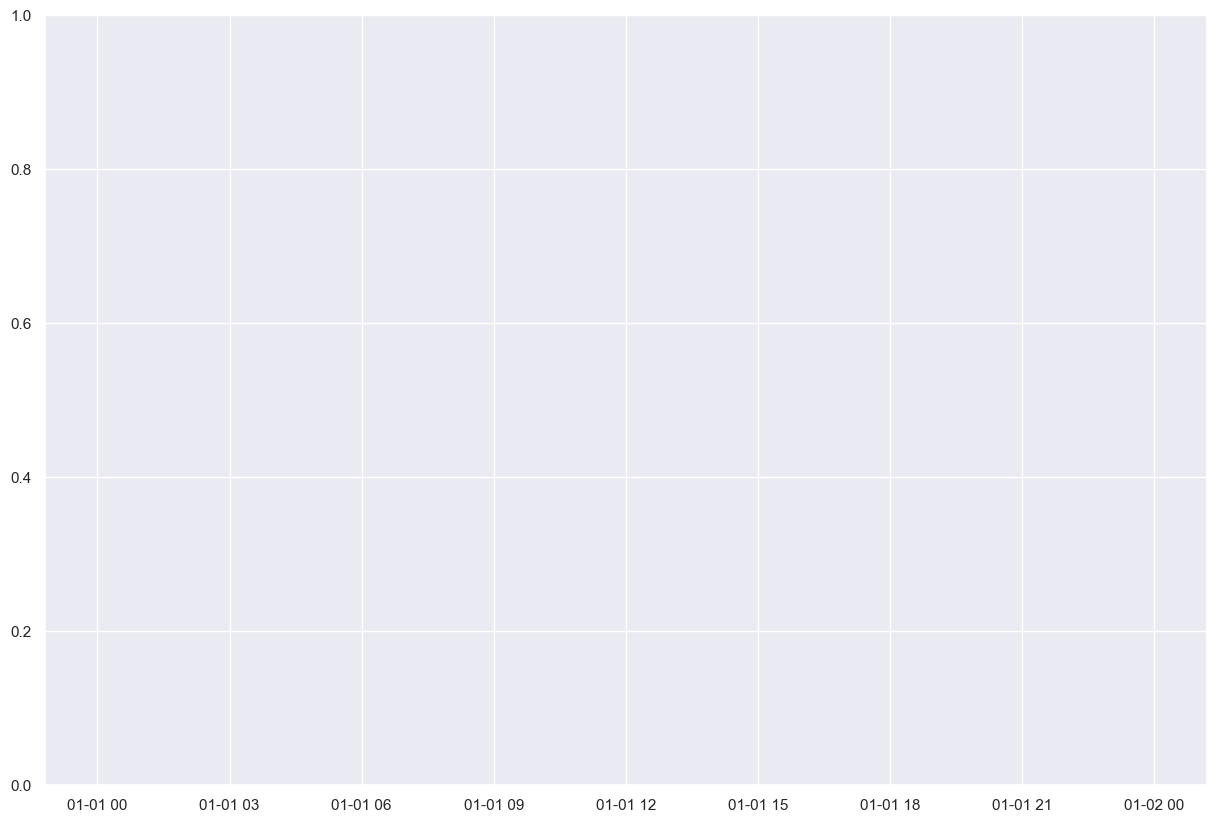

In [ ]:
smart = fetch_scd30_ppm_smart()
smart['type'] = 'smart'
original = fetch_scd30_ppm()
original['type'] = 'original'
print(len(smart), len(original))
graph = pd.concat([original, smart], ignore_index=True)
sns.lineplot(data=graph, x='received_at', y='sensor_value', hue='type')

In [ ]:
from ipywidgets import interact

original = fetch_scd30_ppm()
original['type'] = 'original'

@interact
def interactive_chart(limit=(0, 10000, 100)):
    limit = max(2, limit)
    smart = fetch_scd30_ppm_smart(limit=limit)
    smart['type'] = 'smart'

    graph = pd.concat([original, smart], ignore_index=True)

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=graph, x='received_at', y='sensor_value', hue='type')
    plt.title(f'Chart with top {limit} points')
    plt.show()

interactive(children=(IntSlider(value=5000, description='limit', max=10000, step=100), Output()), _dom_classes…

In [16]:
from ipywidgets import interact

@interact
def interactive_chart(limit=(0, 3000, 1)):
    limit = max(2, limit)
    smart = fetch_scd30_ppm_smart(limit=limit)

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=smart, x='received_at', y='sensor_value')
    plt.title(f'Chart with top {len(smart)} points')
    plt.show()

interactive(children=(IntSlider(value=1500, description='limit', max=3000), Output()), _dom_classes=('widget-i…

In [ ]:
#process_weights()